# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [2]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

CP_text = load_book('../data/Crime-punishment.txt')
BK_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Crime and Punsihment characters: {len(CP_text):,}")
print(f"The Brothers Karamazov characters: {len(BK_text):,}")


c:\Users\dimas\NLP_w2\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crime and Punsihment characters: 1,224,428
The Brothers Karamazov characters: 1,956,237


In [3]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Compute cosine similarity between consecutive paragraph embeddings.

    Low similarity = big topic shift (high drift).
    High similarity = smooth continuation.
    """
    if not paragraphs:
        return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

CP_paras = split_into_paragraphs(CP_text)
BK_paras = split_into_paragraphs(BK_text)

C_drift = topic_drift_embeddings(CP_paras)
B_drift = topic_drift_embeddings(BK_paras)

print(f"CRIME&PUNISHMENT mean similarity between consecutive paragraphs: {sum(C_drift)/len(C_drift):.3f}")
print(f"BROTHERSKARAMAZOV mean similarity between consecutive paragraphs: {sum(B_drift)/len(B_drift):.3f}")


CRIME&PUNISHMENT mean similarity between consecutive paragraphs: 0.542
BROTHERSKARAMAZOV mean similarity between consecutive paragraphs: 0.404


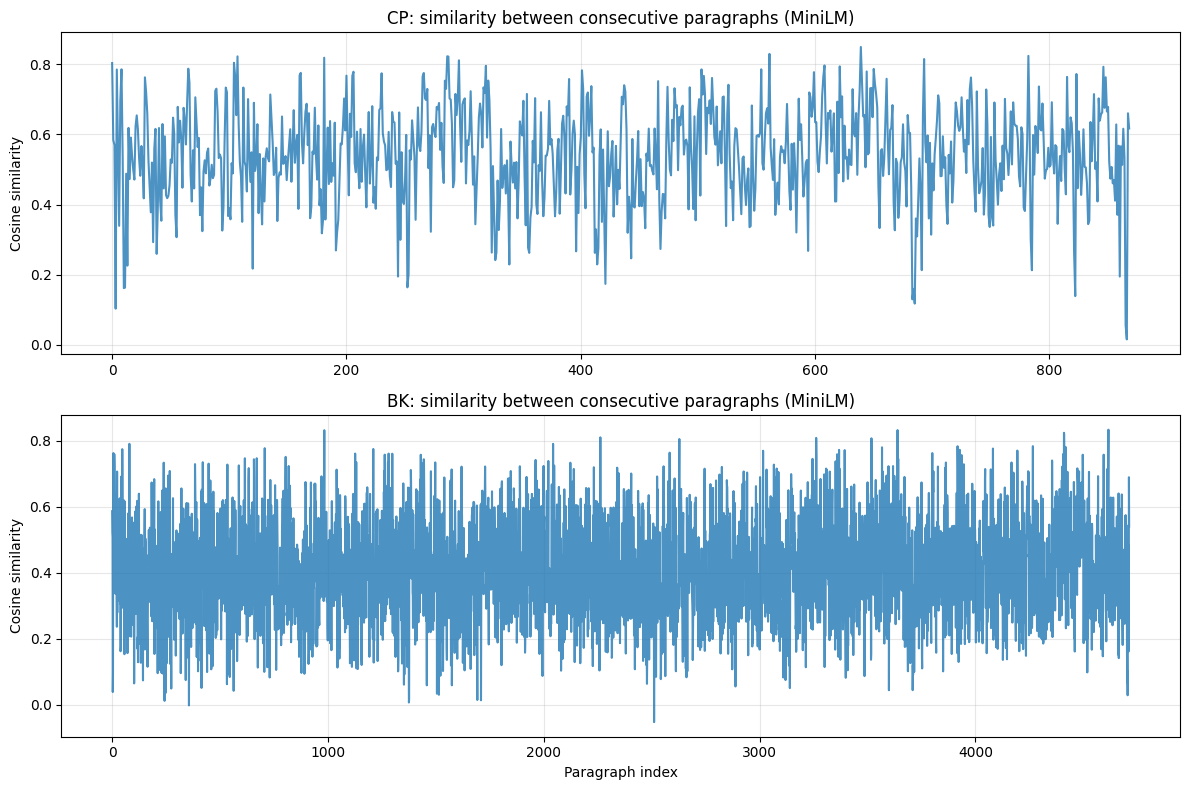

In [4]:
# Visualize topic drift as a line plot (similarity index)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(C_drift, alpha=0.8)
axes[0].set_title('CP: similarity between consecutive paragraphs (MiniLM)')
axes[0].set_ylabel('Cosine similarity')
axes[0].grid(True, alpha=0.3)

axes[1].plot(B_drift, alpha=0.8)
axes[1].set_title('BK: similarity between consecutive paragraphs (MiniLM)')
axes[1].set_xlabel('Paragraph index')
axes[1].set_ylabel('Cosine similarity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
import re

def clean_text(text: str) -> str:
    # Remove everything before "Chapter 1" or similar pattern
    match = re.search(r'Chapter\s+1', text, re.IGNORECASE)
    if match:
        text = text[match.start():]
    # Optionally remove everything after "THE END" or similar
    text = re.split(r'THE END', text, flags=re.IGNORECASE)[0]
    return text

CP_text_clean = clean_text(CP_text)
BK_text_clean = clean_text(BK_text)


In [6]:
import numpy as np

def extract_extreme_paragraphs(paragraphs, sims, peak_threshold=0.9, low_threshold=0.3):
    peak_paragraphs = []
    low_paragraphs = []

    for i, sim in enumerate(sims):
        if sim >= peak_threshold:
            # Append the paragraph pair corresponding to the peak
            peak_paragraphs.append((paragraphs[i], paragraphs[i+1]))
        elif sim <= low_threshold:
            # Append the paragraph pair corresponding to the low
            low_paragraphs.append((paragraphs[i], paragraphs[i+1]))
    
    return peak_paragraphs, low_paragraphs

CP_peaks, CP_lows = extract_extreme_paragraphs(CP_paras, C_drift)
BK_peaks, BK_lows = extract_extreme_paragraphs(BK_paras, B_drift)

print("Example peak paragraphs from Crime & Punishment:")
for p1, p2 in CP_peaks[5:10]:  # show first 2 peaks
    print("---")
    print(p1)
    print(p2)

print("Example low paragraphs (topic shifts):")
for p1, p2 in CP_lows[:2]:
    print("---")
    print(p1)
    print(p2)

for p1, p2 in BK_peaks[:2]:
    print(p1)
    print(p2)
for p1, p2 in BK_lows[:2]:
    print("---")
    print(p1)
    print(p2)



Example peak paragraphs from Crime & Punishment:
Example low paragraphs (topic shifts):
---
Barnes & Noble.com, 76 Ninth Avenue, New York, NY 10011.
How could a nineteenth-century Russian novel still capture the twenty-first century psyche? The mar- riage between love and hate as well as a grotesque look into the human psychological condition is pre- cisely what draws readers to a masterpiece such as Crime and Punishment. The novel’s timelessness is the result of its ongoing relevance to society as well as the enigma of crime itself. Fyodor Dostoevsky takes pains to show us the inevitability of this cycle of crime through the beautifully crafted characters and twisted plots of this work. Simply titled, Crime and Punishment’s timelessness is the result of its ongoing prevalence in society as well as the enigma of crime itself. Those who weigh testimonials and create laws realize that part of the problem of understanding and preventing crime is to understand the nature of the criminal mi

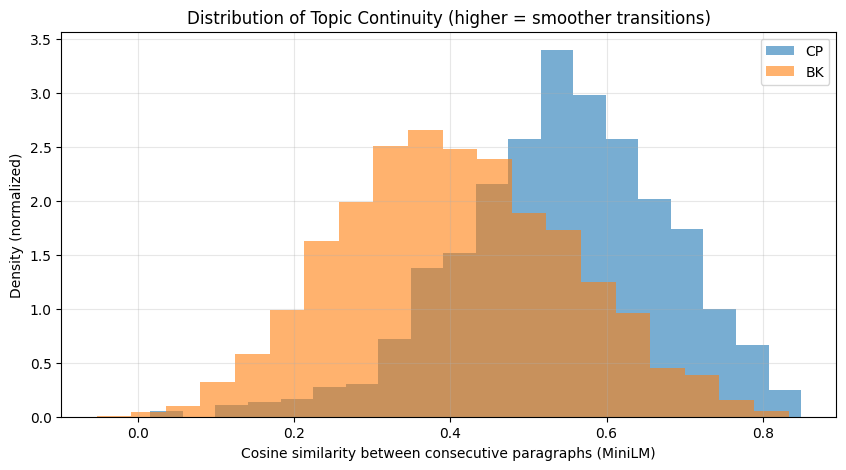

In [9]:
# Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(C_drift, bins=20, alpha=0.6, label='CP', density=True)
ax.hist(B_drift, bins=20, alpha=0.6, label='BK', density=True)
ax.set_xlabel('Cosine similarity between consecutive paragraphs (MiniLM)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Topic Continuity (higher = smoother transitions)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [10]:
import gc

# Delete large variables to free memory
del CP_text, BK_text
del CP_paras, BK_paras
del C_drift, B_drift

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
